<a href="https://colab.research.google.com/github/ImVis10/1PercentStrategy/blob/master/1PercentStrategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import csv  
import time
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

In [3]:
API_KEY = 'OTPBXZ24V7Q9A24S'

In [4]:
def write_to_csv(stock,data, mode):


  # header = ['time', 'open', 'high', 'low', 'close', 'volume']

  with open("data/"+stock+'_minute.csv', mode, encoding='UTF8') as f:
      writer = csv.writer(f)
      writer.writerow(data)

In [5]:
time_periods ={
    '1':'year1month1',
    '2':'year1month2',
    '3':'year1month3',
    '4':'year1month4',
    '5':'year1month5',
    '6':'year1month6',
    '7':'year1month7',
    '8':'year1month8',
    '9':'year1month9',
    '10':'year1month10',
    '11':'year1month11',
    '12':'year1month12',
    '13':'year2month1',
    '14':'year2month2',
    '15':'year2month3',
    '16':'year2month4',
    '17':'year2month5',
    '18':'year2month6',
    '19':'year2month7',
    '20':'year2month8',
    '21':'year2month9',
    '22':'year2month10',
    '23':'year2month11',
    '24':'year2month12',
}

In [6]:
import csv
import requests

def get_stock_csv(stock_name):
  # Run only 5 time periods in a minute to not exceed the API hits
  num_calls_in_a_minute = 0
  max_calls_in_a_minute = 5
  for month, time_period in time_periods.items():
    CSV_URL = 'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY_EXTENDED&symbol=%(stock)s&interval=1min&slice=%(slice)s&apikey=%(key)s&adjusted=false'\
            %{'stock':stock_name,'slice':time_period,'key':API_KEY}
    with requests.Session() as s:
        if num_calls_in_a_minute == max_calls_in_a_minute:
            num_calls_in_a_minute = 0
            time.sleep(60)
        print(time_period)
        download = s.get(CSV_URL)
        num_calls_in_a_minute += 1
        decoded_content = download.content.decode('utf-8')
        cr = csv.reader(decoded_content.splitlines(), delimiter=',')
        my_list = list(cr)
        for row in my_list:
          if 'open' not in row:
            write_to_csv(stock_name, row,'a')
        

In [7]:
def get_stock_data(stock_name):
    mode = 'r'
    interval = 'minute'
    file_path = 'data/' + stock_name+'_' + interval +'.csv'
    minute_data = []
    with open(file_path) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
                minute_data.append(list(row))
    return minute_data

In [9]:
TSLA_minute_data = get_stock_data('TSLA')
AAPL_minute_data = get_stock_data('AAPL')
STNG_minute_data = get_stock_data('STNG')
SPY_minute_data = get_stock_data('SPY')
# GOOG_minute_data = get_stock_data('GOOG')




In [10]:
def get_daily_opening_candle(minute_data):
  daily_opening_candle = []
  date_and_time = minute_data[0][0].split()
  current_date = date_and_time[0]
  for i in range(len(minute_data)):
    date_and_time = minute_data[i][0].split()
    end_date = date_and_time[0]


    # if there is a change in the current_date, get the data
    if (current_date != end_date):
      daily_opening_candle.append(minute_data[i-1])
      current_date = end_date

  daily_opening_candle.append(minute_data[-1])
  daily_opening_candle.reverse()
  return daily_opening_candle

In [11]:
TSLA_daily_opening_candle = get_daily_opening_candle(TSLA_minute_data)
AAPL_daily_opening_candle = get_daily_opening_candle(AAPL_minute_data)
STNG_daily_opening_candle = get_daily_opening_candle(STNG_minute_data)
SPY_daily_opening_candle = get_daily_opening_candle(SPY_minute_data)
# GOOG_daily_opening_candle = get_daily_opening_candle(GOOG_minute_data)



In [12]:
def get_daily_closing_candle(minute_data):
    daily_closing_candle=[]
    current_date = ''
    for i in range(len(minute_data)):
        date_and_time = minute_data[i][0].split()
        end_date = date_and_time[0]

        # if there is a change in the current_date, get the data
        if (current_date != end_date):
            daily_closing_candle.append(minute_data[i])
            current_date = end_date

    daily_closing_candle.reverse()
    return daily_closing_candle


In [13]:
TSLA_daily_closing_candle = get_daily_closing_candle(TSLA_minute_data)
AAPL_daily_closing_candle = get_daily_closing_candle(AAPL_minute_data)
STNG_daily_closing_candle = get_daily_closing_candle(STNG_minute_data)
SPY_daily_closing_candle = get_daily_closing_candle(SPY_minute_data)


In [14]:
# Initialize
PRINCIPAL = 1000
returns = []
returns.append(PRINCIPAL)
num_trades = 0


In [17]:
def close_trade(gain_or_loss):
    global PRINCIPAL
    global num_trades
    global returns
    PRINCIPAL += gain_or_loss
    returns.append(PRINCIPAL)
    num_trades += 1


In [18]:
def get_time_series(date, minute_data):

    time_series_data = []

    for i in range(1, len(minute_data) ):
        current_date = minute_data[i][0].split()[0]
        if (current_date == date):
            time_series_data.append(minute_data[i])
            next_date = minute_data[i+1][0].split()[0]
            if (current_date != next_date):
                break
    time_series_data.reverse()
    return time_series_data

In [22]:
# Principal
# Current_principal = Principal - buying_price
# Once stock_price meets desired profit(gain)
# Exit trade => Current_principal = current_principal + buying_price + Gain
########################### Go bull ##################

# Buy
# Wait until you make desired profit or hit the SL
# Exit
def go_bull(profit_percent, buy_price, time_series_data):
    target = buy_price + (buy_price * profit_percent)
    stop_loss = profit_percent/2
    bottom_line = buy_price - (buy_price*stop_loss)
    # Start from second entry because we entered at first entry
    global PRINCIPAL
    num_stocks_bought = (PRINCIPAL)/buy_price
    for row in time_series_data[1:]:
        # Check for stop loss first
        #  Comparing with open and low
        if (max(float(row[1]), float(row[3])) <= bottom_line):
            close_trade((max(float(row[1]), float(row[3])) - buy_price) * num_stocks_bought)
            return None
        # Comparing with open and high
        if (float(row[1]), float(row[2]) >= target):
            close_trade((max(float(row[1]), float(row[2])) - buy_price) * num_stocks_bought)
            return None
    close_trade(buy_price - float(time_series_data[-1][4]))


In [23]:
# Principal
# Current_principal = Principal - selling_price
# Once stock_price meets desired profit(gain)
# Exit trade => Current_principal = current_principal + selling_price + Gain
########################### Go bear ##################

# Sell
# Wait until you make desired profit or hit the SL
# Exit

def go_bear(profit_percent, sell_price, time_series_data):
    target = sell_price - (sell_price * profit_percent)
    stop_loss = profit_percent/2
    top_line = sell_price + (sell_price*stop_loss)

    global PRINCIPAL                                       
    # Start from second entry because we entered at first entry
    num_stocks_sold = (PRINCIPAL)/sell_price                 
    for row in time_series_data[1:]:
        # Check for stop loss first
        #  Comparing with open and high
        if (min(float(row[1]), float(row[2])) >= top_line):
            close_trade((sell_price - min(float(row[1]), float(row[2]))) * num_stocks_sold)
            return None
        # Comparing with open and low
        if (min(float(row[1]), float(row[3])) <= target):
            close_trade((sell_price - min(float(row[1]), float(row[3]))) * num_stocks_sold)
            return None
    # Neither conditions hit. Close at the end of the trading day
    close_trade(sell_price - float(time_series_data[-1][4]))


In [24]:
def run_simulation(profit_percentage, diff_between_trading_sessions, minute_data, daily_opening_candle, daily_closing_candle):
    for i in range(len(daily_opening_candle)-1):

        prev_stock_price = float(daily_closing_candle[i][4])
        stock_price = float(daily_opening_candle[i+1][4])

        bullish_condition = stock_price > prev_stock_price * \
            (1 + diff_between_trading_sessions)
        bearish_condition = stock_price < prev_stock_price * \
            (1 - diff_between_trading_sessions)

        if (bullish_condition):
            time_series = get_time_series(
                daily_opening_candle[i+1][0].split()[0], minute_data)
            go_bull(profit_percentage, stock_price, time_series)

        elif (bearish_condition):
            time_series = get_time_series(
                daily_opening_candle[i+1][0].split()[0], minute_data)
            go_bear(profit_percentage, stock_price, time_series)
        else:
          global returns
          returns.append(PRINCIPAL)



# TSLA
1. Profit percentage = 1%
2. Difference between trading sessions = 0.5%

In [25]:
PRINCIPAL = 1000
num_trades = 0
returns = [PRINCIPAL]
profit_percentage = 0.5/100
diff_between_trading_sessions = 0.1/100

run_simulation(profit_percentage, diff_between_trading_sessions,TSLA_minute_data,TSLA_daily_opening_candle, TSLA_daily_closing_candle)
print('Cash in hand: ', PRINCIPAL)
print('Number of days traded in 2 years: ', num_trades)

return1 = returns

Cash in hand:  1583.162516807719
Number of days traded in 2 years:  440


In [26]:
PRINCIPAL = 1000
num_trades = 0
profit_percentage = 0.1/100
diff_between_trading_sessions = 0.1/100
returns = [PRINCIPAL]
run_simulation(profit_percentage, diff_between_trading_sessions,TSLA_minute_data,TSLA_daily_opening_candle, TSLA_daily_closing_candle)
print('Cash in hand: ', PRINCIPAL)
print('Number of days traded in 2 years: ', num_trades)
return2 = returns

Cash in hand:  1567.150375396066
Number of days traded in 2 years:  440


In [27]:
PRINCIPAL = 1000
num_trades = 0
profit_percentage = 1/100
diff_between_trading_sessions = 1/100
returns = [PRINCIPAL]
run_simulation(profit_percentage, diff_between_trading_sessions,TSLA_minute_data,TSLA_daily_opening_candle, TSLA_daily_closing_candle)
print('Cash in hand: ', PRINCIPAL)
print('Number of days traded in 2 years: ', num_trades)
return3 = returns

Cash in hand:  1242.193714680275
Number of days traded in 2 years:  140


In [28]:
PRINCIPAL = 1000
num_trades = 0
profit_percentage = 3/100
diff_between_trading_sessions = .1/100
returns = [PRINCIPAL]
run_simulation(profit_percentage, diff_between_trading_sessions,TSLA_minute_data,TSLA_daily_opening_candle, TSLA_daily_closing_candle)
print('Cash in hand: ', PRINCIPAL)
print('Number of days traded in 2 years: ', num_trades)
return4 = returns

Cash in hand:  1093.1796061490336
Number of days traded in 2 years:  440


In [29]:
PRINCIPAL = 1000
num_trades = 0
profit_percentage = 7/100
diff_between_trading_sessions = .1/100
returns = [PRINCIPAL]
run_simulation(profit_percentage, diff_between_trading_sessions,TSLA_minute_data,TSLA_daily_opening_candle, TSLA_daily_closing_candle)
print('Cash in hand: ', PRINCIPAL)
print('Number of days traded in 2 years: ', num_trades)
return5 = returns

Cash in hand:  1268.7314516996366
Number of days traded in 2 years:  440


In [30]:
global trade_dates 
trade_dates = [ x[0].split()[0] for x in TSLA_daily_opening_candle ]

<ipython-input-31-26a9342e2234>:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(111)


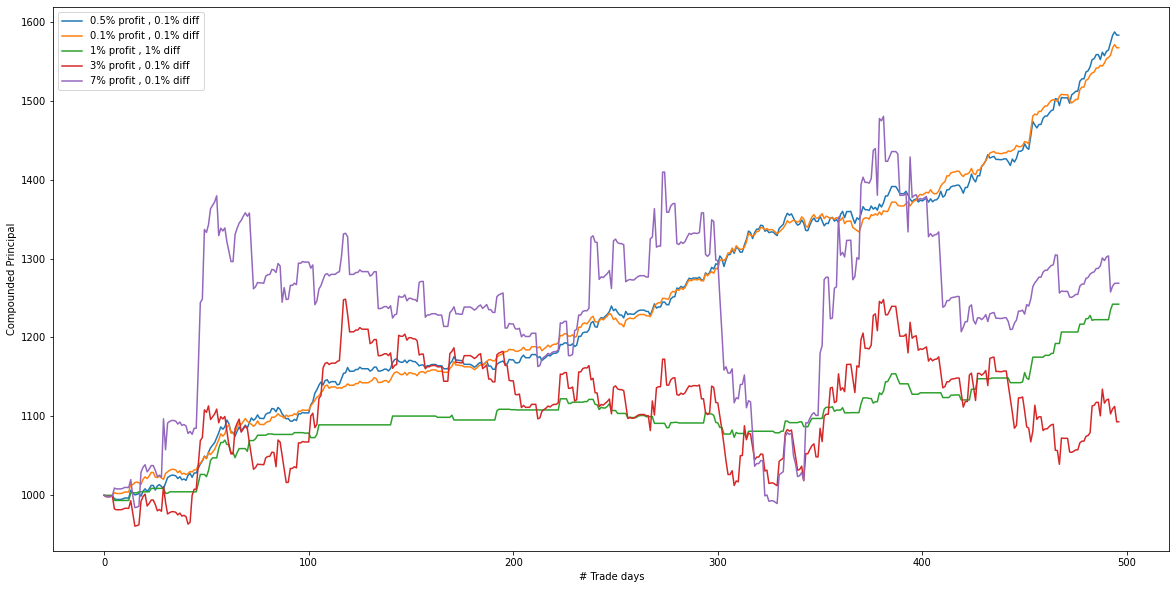

In [31]:
plt.ylabel('Compounded Principal')
plt.xlabel('# Trade days')
ax = plt.subplot(111)

y = len(trade_dates)
ax.plot(return1 , label = '0.5% profit , 0.1% diff' )
ax.plot(return2,  label = '0.1% profit , 0.1% diff')
ax.plot(return3,   label = '1% profit , 1% diff')
ax.plot(return4,  label = '3% profit , 0.1% diff')
ax.plot(return5,  label = '7% profit , 0.1% diff')
ax.legend()
plt.show()

# AAPL
1. Profit percentage = 1%
2. Difference between trading sessions = 0.5%

In [33]:
PRINCIPAL = 1000
num_trades = 0
profit_percentage = 0.5/100
diff_between_trading_sessions = 0.1/100

run_simulation(profit_percentage, diff_between_trading_sessions,AAPL_minute_data,AAPL_daily_opening_candle, AAPL_daily_closing_candle)
print('Cash in hand: ', PRINCIPAL)
print('Number of days traded in 2 years: ', num_trades)
return1 = returns

Cash in hand:  1231.2813679470692
Number of days traded in 2 years:  390


# STNG
1. Profit percentage = 1%
2. Difference between trading sessions = 0.5%

In [34]:
PRINCIPAL = 1000
num_trades = 0
returns = [PRINCIPAL]
# Highly fluctuating stocks :
# Be conservative about when you enter the trade
# Aim for high targets
profit_percentage = 0.5/100
diff_between_trading_sessions = 0.1/100

run_simulation(profit_percentage, diff_between_trading_sessions,STNG_minute_data,STNG_daily_opening_candle, STNG_daily_closing_candle)
print('Cash in hand: ', PRINCIPAL)
print('Number of days traded in 2 years: ', num_trades)
return1 = returns

Cash in hand:  413.72556663082645
Number of days traded in 2 years:  420


In [35]:
PRINCIPAL = 1000
num_trades = 0

returns = [PRINCIPAL]
# Highly fluctuating stocks :
# Be conservative about when you enter the trade
# Aim for high targets
profit_percentage = 0.5/100
diff_between_trading_sessions = 2/100

run_simulation(profit_percentage, diff_between_trading_sessions,STNG_minute_data,STNG_daily_opening_candle, STNG_daily_closing_candle)
print('Cash in hand: ', PRINCIPAL)
print('Number of days traded in 2 years: ', num_trades)
return2 = returns

Cash in hand:  606.1328472824035
Number of days traded in 2 years:  79


In [36]:
PRINCIPAL = 1000
num_trades = 0

returns = [PRINCIPAL]
# Highly fluctuating stocks :
# Be conservative about when you enter the trade
# Aim for high targets
profit_percentage = 0.5/100
diff_between_trading_sessions = 2.5/100

run_simulation(profit_percentage, diff_between_trading_sessions,STNG_minute_data,STNG_daily_opening_candle, STNG_daily_closing_candle)
print('Cash in hand: ', PRINCIPAL)
print('Number of days traded in 2 years: ', num_trades)
return3 = returns

Cash in hand:  693.394882275883
Number of days traded in 2 years:  52


<ipython-input-37-adf0ce8e869f>:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(111)


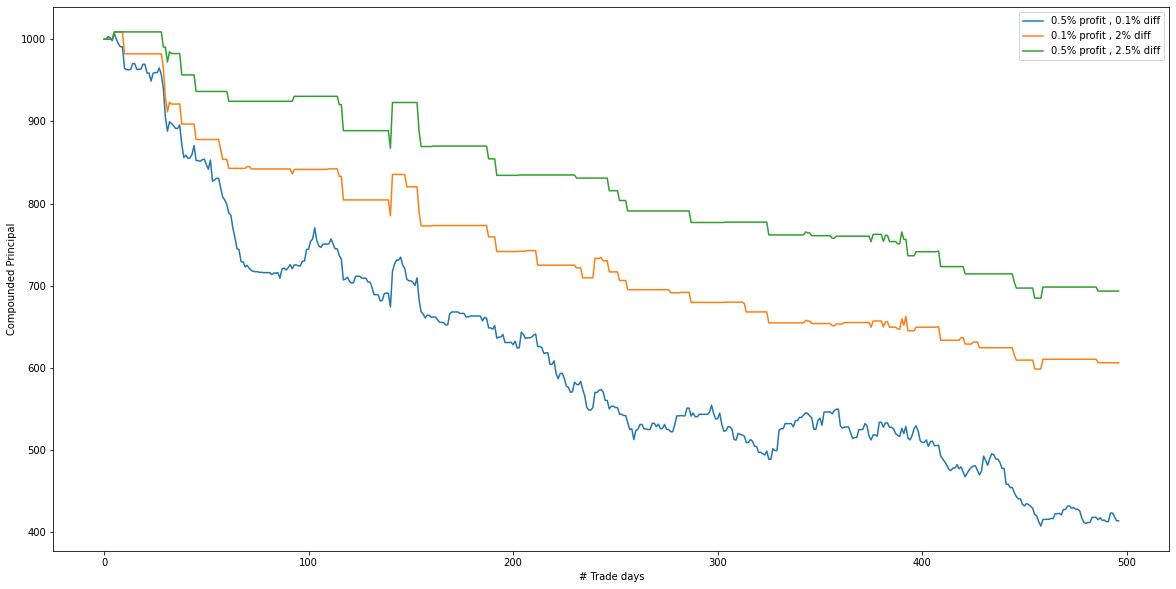

In [37]:
plt.ylabel('Compounded Principal')
plt.xlabel('# Trade days')
ax = plt.subplot(111)

ax.plot(return1 , label = '0.5% profit , 0.1% diff' )
ax.plot(return2,  label = '0.1% profit , 2% diff')
ax.plot(return3,   label = '0.5% profit , 2.5% diff')
ax.legend()
plt.show()

# SPY
1. Profit percentage = 1%
2. Difference between trading sessions = 0.5%

In [38]:
PRINCIPAL = 1000
num_trades = 0
profit_percentage = 0.5/100
diff_between_trading_sessions = 0.1/100

run_simulation(profit_percentage, diff_between_trading_sessions,SPY_minute_data,SPY_daily_opening_candle, SPY_daily_closing_candle)
print('Cash in hand: ', PRINCIPAL)
print('Number of days traded in 2 years: ', num_trades)

Cash in hand:  1036.3185964369359
Number of days traded in 2 years:  368


In [39]:
PRINCIPAL = 1000
num_trades = 0
profit_percentage = 0.07/100
diff_between_trading_sessions = 0.01/100

run_simulation(profit_percentage, diff_between_trading_sessions,SPY_minute_data,SPY_daily_opening_candle, SPY_daily_closing_candle)
print('Cash in hand: ', PRINCIPAL)
print('Number of days traded in 2 years: ', num_trades)

Cash in hand:  1057.9283188437478
Number of days traded in 2 years:  481


In [40]:
PRINCIPAL = 1000
num_trades = 0
profit_percentage = 0.1/100
diff_between_trading_sessions = 0.01/100

run_simulation(profit_percentage, diff_between_trading_sessions,SPY_minute_data,SPY_daily_opening_candle, SPY_daily_closing_candle)
print('Cash in hand: ', PRINCIPAL)
print('Number of days traded in 2 years: ', num_trades)

Cash in hand:  1059.9225325565114
Number of days traded in 2 years:  481


In [41]:
PRINCIPAL = 1000
num_trades = 0
profit_percentage = 2/100
diff_between_trading_sessions = 0.5/100

run_simulation(profit_percentage, diff_between_trading_sessions,SPY_minute_data,SPY_daily_opening_candle, SPY_daily_closing_candle)
print('Cash in hand: ', PRINCIPAL)
print('Number of days traded in 2 years: ', num_trades)

Cash in hand:  883.0510645852712
Number of days traded in 2 years:  102
